In [1]:
import pandas as pd
import numpy as np

train_meta = pd.read_csv("./train/train_metadata.csv")
train_add_features = pd.read_csv("./train/features/additional_features.csv")
train_color_hist = pd.read_csv("./train/features/color_histogram.csv")
train_hog_pca = pd.read_csv("./train/features/hog_pca.csv")


test_meta = pd.read_csv("./test/test_metadata.csv")
# test_meta.drop("ClassId", inplace=True, axis=1) # useless for now
test_add_features = pd.read_csv("./test/features/additional_features.csv")
test_color_hist = pd.read_csv("./test/features/color_histogram.csv")
test_hog_pca = pd.read_csv("./test/features/hog_pca.csv")

In [2]:
# merging all the dataframes

train_df = pd.merge(train_meta, train_add_features, on = "image_path", how = "left")
train_df = pd.merge(train_df, train_color_hist, on = "image_path", how = "left")
train_df = pd.merge(train_df, train_hog_pca, on = "image_path", how = "left")

test_df = pd.merge(test_meta, test_add_features, on = "image_path", how = "left")
test_df = pd.merge(test_df, test_color_hist, on = "image_path", how = "left")
test_df = pd.merge(test_df, test_hog_pca, on = "image_path", how = "left")


# this is just better for reading files
train_df["image_path"] = train_df["image_path"].apply(lambda x : "train/" + x)
test_df["image_path"] = test_df["image_path"].apply(lambda x : "test/" + x)

In [3]:
train_df = train_df[["image_path", "ClassId", "id"]]

test_df = test_df[["image_path", "ClassId", "id"]]

# Prepare Data For CNN

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

# Test if GPU boosting is enabled
print(tf.config.list_physical_devices('GPU'))

# Define image dimensions - smaller for faster training
IMG_HEIGHT, IMG_WIDTH = 72, 72

def load_images(image_paths, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    images = []
    for path in image_paths:
        bgr = cv2.imread(path)
        if bgr is None:
            continue
        bgr = bgr[3:-3, 3:-3]  # Crop 3 pixels from each side
        bgr = cv2.resize(bgr, (img_width, img_height))
        
        # 2) Normalize to [0,1]
        bgr_norm = bgr.astype('float32') / 255.0
        b, g, r = cv2.split(bgr_norm)
        
        # 3) Compute luma (Rec.601)
        luma = 0.299 * r + 0.587 * g + 0.114 * b
        
        # 4) Opponent colour channels
        red_green   = r - g
        blue_yellow = b - (r + g) / 2.0
        
        # 5) Compute Sobel edges on the luma channel
        sobel_x = cv2.Sobel(luma, cv2.CV_32F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(luma, cv2.CV_32F, 0, 1, ksize=3)
        # Optionally scale to roughly [-1,1]:
        sobel_x = sobel_x / 4.0
        sobel_y = sobel_y / 4.0
        
        # 6) Stack into a 5-channel image
        img_feat = np.dstack((luma,
                              red_green,
                              blue_yellow))
                            #   sobel_x,
                            #   sobel_y))  # shape = (H, W, 5)
        
        images.append(img_feat)
    
    return np.array(images)  # → (N, img_height, img_width, 5)

# Get image paths and labels from train_df
image_paths = train_df['image_path'].values
labels = train_df['ClassId'].values

# Load images
X_images = load_images(image_paths)

# Split the data
idx = np.arange(len(X_images))
train_idx, val_idx = train_test_split(
    idx,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

X_train_img = X_images[train_idx]
y_train_img = labels[train_idx]
X_val_img   = X_images[val_idx]
y_val_img   = labels[val_idx]

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Train CNN

In [7]:
# Data augmentation with fewer transformations for speed
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=(0.6,1.4),
    zoom_range=0.2,
    shear_range=0.1,
    channel_shift_range=0.1,
)

# Build a custom CNN model for grayscale images
def build_cnn_model(num_classes=43):
    model = tf.keras.models.load_model("best_cnn_model_99_899.h5")
    # model = models.Sequential([
    #     # First Convolutional Block
    #     layers.Conv2D(
    #         32, (3, 3), activation='relu', padding='same',
    #         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    #         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    #     ),
    #     layers.BatchNormalization(),
    #     layers.Conv2D(
    #         32, (3, 3), activation='relu', padding='same',
    #         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    #     ),
    #     layers.BatchNormalization(),
    #     layers.MaxPooling2D(pool_size=(2, 2)),
    #     layers.Dropout(0.25),

    #     # Second Convolutional Block
    #     layers.Conv2D(
    #         64, (3, 3), activation='relu', padding='same',
    #         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    #     ),
    #     layers.BatchNormalization(),
    #     layers.Conv2D(
    #         64, (3, 3), activation='relu', padding='same',
    #         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    #     ),
    #     layers.BatchNormalization(),
    #     layers.MaxPooling2D(pool_size=(2, 2)),
    #     layers.Dropout(0.25),

    #     # Third Convolutional Block
    #     layers.Conv2D(
    #         128, (3, 3), activation='relu', padding='same',
    #         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    #     ),
    #     layers.BatchNormalization(),
    #     layers.Conv2D(
    #         128, (3, 3), activation='relu', padding='same',
    #         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    #     ),
    #     layers.BatchNormalization(),
    #     layers.MaxPooling2D(pool_size=(2, 2)),
    #     layers.Dropout(0.25),

    #     # Dense Layers
    #     layers.GlobalAveragePooling2D(),
    #     layers.Dense(
    #         128, activation='relu',
    #         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    #     ),
    #     layers.BatchNormalization(),
    #     layers.Dropout(0.5),
    #     layers.Dense(
    #         num_classes, activation='softmax',
    #         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    #     )
    # ])
    
    return model

cnn_model = build_cnn_model()
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Lower learning rate for better generalization
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy instead of loss
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Add model checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

BATCH_SIZE = 32
# Train model with focus on validation metrics
history = cnn_model.fit(
    # X_train_img, y_train_img,
    datagen.flow(X_train_img, y_train_img, batch_size=BATCH_SIZE),
    # batch_size=32,  # Smaller batch size for better generalization
    validation_data=(X_val_img, y_val_img),
    epochs=50,  
    callbacks=[reduce_lr, early_stopping, checkpoint],
    verbose=1
)

# Load the best model saved during training
cnn_model = tf.keras.models.load_model('best_cnn_model.h5')

# Evaluate model
val_loss, val_acc = cnn_model.evaluate(X_val_img, y_val_img)
print(f"Validation accuracy: {val_acc:.4f}")

# Make predictions on test set
test_image_paths = test_df['image_path'].values
X_test_img = load_images(test_image_paths)
cnn_predictions = cnn_model.predict(X_test_img)
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

# Save CNN predictions
cnn_pred_df = pd.DataFrame({'id': test_df['id'], 'ClassId': cnn_pred_classes})
cnn_pred_df.set_index('id', inplace=True)
cnn_pred_df.to_csv('cnn_predictions.csv')

2025-05-17 17:49:48.417530: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-17 17:49:48.417707: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-17 17:49:48.417710: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-17 17:49:48.417954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-17 17:49:48.417966: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


/Users/micha31r/Documents/GitHub/ml-ass2/tf-metal/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-17 17:49:49.916753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9178 - loss: 0.4719
Epoch 1: val_accuracy improved from -inf to 0.99271, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9178 - loss: 0.4719 - val_accuracy: 0.9927 - val_loss: 0.1940 - learning_rate: 5.0000e-04
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9231 - loss: 0.4672
Epoch 2: val_accuracy improved from 0.99271 to 0.99727, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9231 - loss: 0.4672 - val_accuracy: 0.9973 - val_loss: 0.1842 - learning_rate: 5.0000e-04
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9188 - loss: 0.4793
Epoch 3: val_accuracy improved from 0.99727 to 0.99818, saving model to best_cnn_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9189 - loss: 0.4792 - val_accuracy: 0.9982 - val_loss: 0.1838 - learning_rate: 5.0000e-04
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9215 - loss: 0.4634
Epoch 4: val_accuracy did not improve from 0.99818
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9215 - loss: 0.4635 - val_accuracy: 0.9936 - val_loss: 0.1997 - learning_rate: 5.0000e-04
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9272 - loss: 0.4502
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 5: val_accuracy did not improve from 0.99818
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9272 - loss: 0.4503 - val_accuracy: 0.9945 - val_loss: 0.1908 - learning_rate: 5.0000e-04
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9289 - loss: 0.4482
Epoch 6: val_accuracy did not improve from 0.99818
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9289 - loss: 0

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9997 - loss: 0.1794
Validation accuracy: 0.9982
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


# Show Misclassified Images In The Validation Set

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Mismatched predictions:
Total mismatches: 1

Sample of mismatches:
                image_path  ClassId  predicted
3327  train/img_003328.jpg        2          1


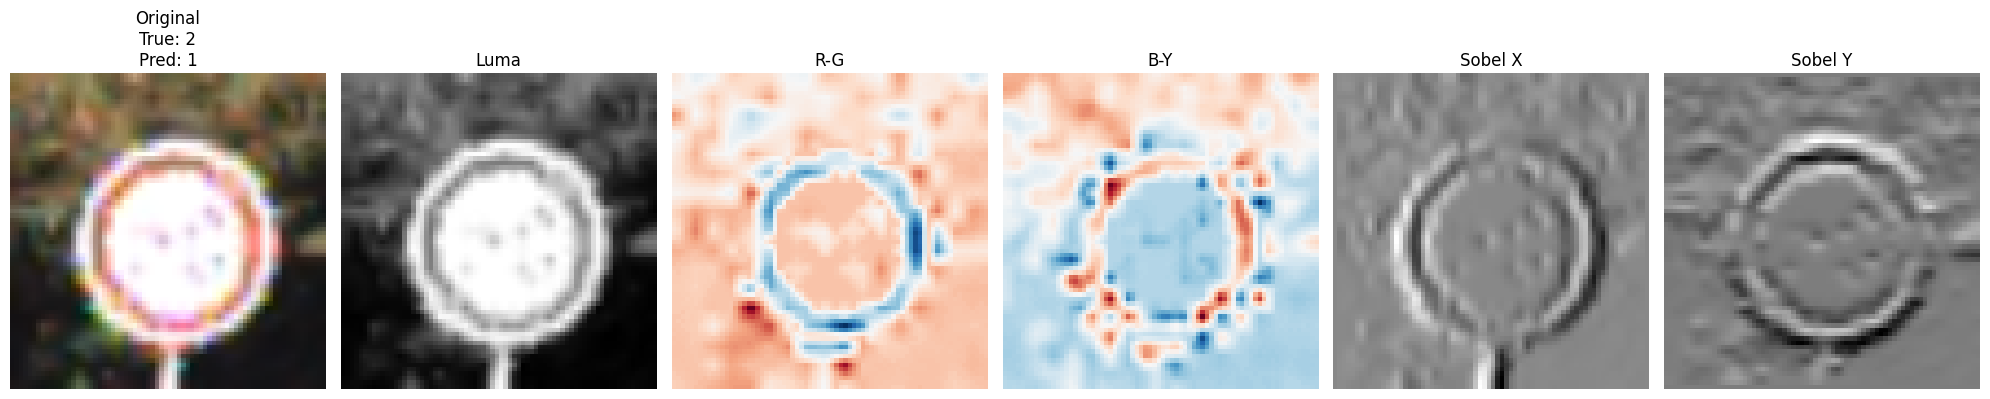

<Figure size 640x480 with 0 Axes>

In [27]:
from matplotlib import pyplot as plt

# Load the model and get predictions
cnn_model = tf.keras.models.load_model('best_cnn_model_99_899.h5')
probs = cnn_model.predict(X_val_img)
pred_indices = np.argmax(probs, axis=1)

# Get the validation data paths
validation_df = train_df.iloc[val_idx].copy()

# Add predictions to the dataframe
validation_df['predicted'] = pred_indices

# Find where predictions don't match true labels
mismatches = validation_df[validation_df['predicted'] != validation_df['ClassId']]

# Display the results
print("\nMismatched predictions:")
print(f"Total mismatches: {len(mismatches)}")
print("\nSample of mismatches:")
print(mismatches[['image_path', 'ClassId', 'predicted']].head(10))

num_images = len(mismatches)

plt.figure(figsize=(20, 4 * num_images))  # Adjust figure size for multiple rows

for idx, (_, row) in enumerate(mismatches.head(num_images).iterrows()):
    # Load and process image
    bgr = cv2.imread(row['image_path'])
    if bgr is None:
        continue
        
    # Resize and normalize
    bgr = cv2.resize(bgr, (IMG_WIDTH, IMG_HEIGHT)).astype('float32') / 255.0
    b, g, r = cv2.split(bgr)
    
    # Compute channels
    luma = 0.299 * r + 0.587 * g + 0.114 * b
    red_green = r - g
    blue_yellow = b - (r + g) / 2.0
    
    # Compute Sobel edges
    sobel_x = cv2.Sobel(luma, cv2.CV_32F, 1, 0, ksize=3) / 4.0
    sobel_y = cv2.Sobel(luma, cv2.CV_32F, 0, 1, ksize=3) / 4.0
    
    # Plot original image
    plt.subplot(num_images, 6, idx * 6 + 1)
    plt.imshow(cv2.cvtColor((bgr * 255).astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title(f'Original\nTrue: {row["ClassId"]}\nPred: {row["predicted"]}')
    plt.axis('off')
    
    # Plot luma
    plt.subplot(num_images, 6, idx * 6 + 2)
    plt.imshow(luma, cmap='gray')
    plt.title('Luma')
    plt.axis('off')
    
    # Plot red-green
    plt.subplot(num_images, 6, idx * 6 + 3)
    plt.imshow(red_green, cmap='RdBu')
    plt.title('R-G')
    plt.axis('off')
    
    # Plot blue-yellow
    plt.subplot(num_images, 6, idx * 6 + 4)
    plt.imshow(blue_yellow, cmap='RdBu')
    plt.title('B-Y')
    plt.axis('off')
    
    # Plot Sobel X
    plt.subplot(num_images, 6, idx * 6 + 5)
    plt.imshow(sobel_x, cmap='gray')
    plt.title('Sobel X')
    plt.axis('off')
    
    # Plot Sobel Y
    plt.subplot(num_images, 6, idx * 6 + 6)
    plt.imshow(sobel_y, cmap='gray')
    plt.title('Sobel Y')
    plt.axis('off')

plt.tight_layout()
plt.show()

plt.savefig('mismatched_images.png')
mismatches.to_csv('mismatched_images.csv')

# Compare Best and Current Predictions

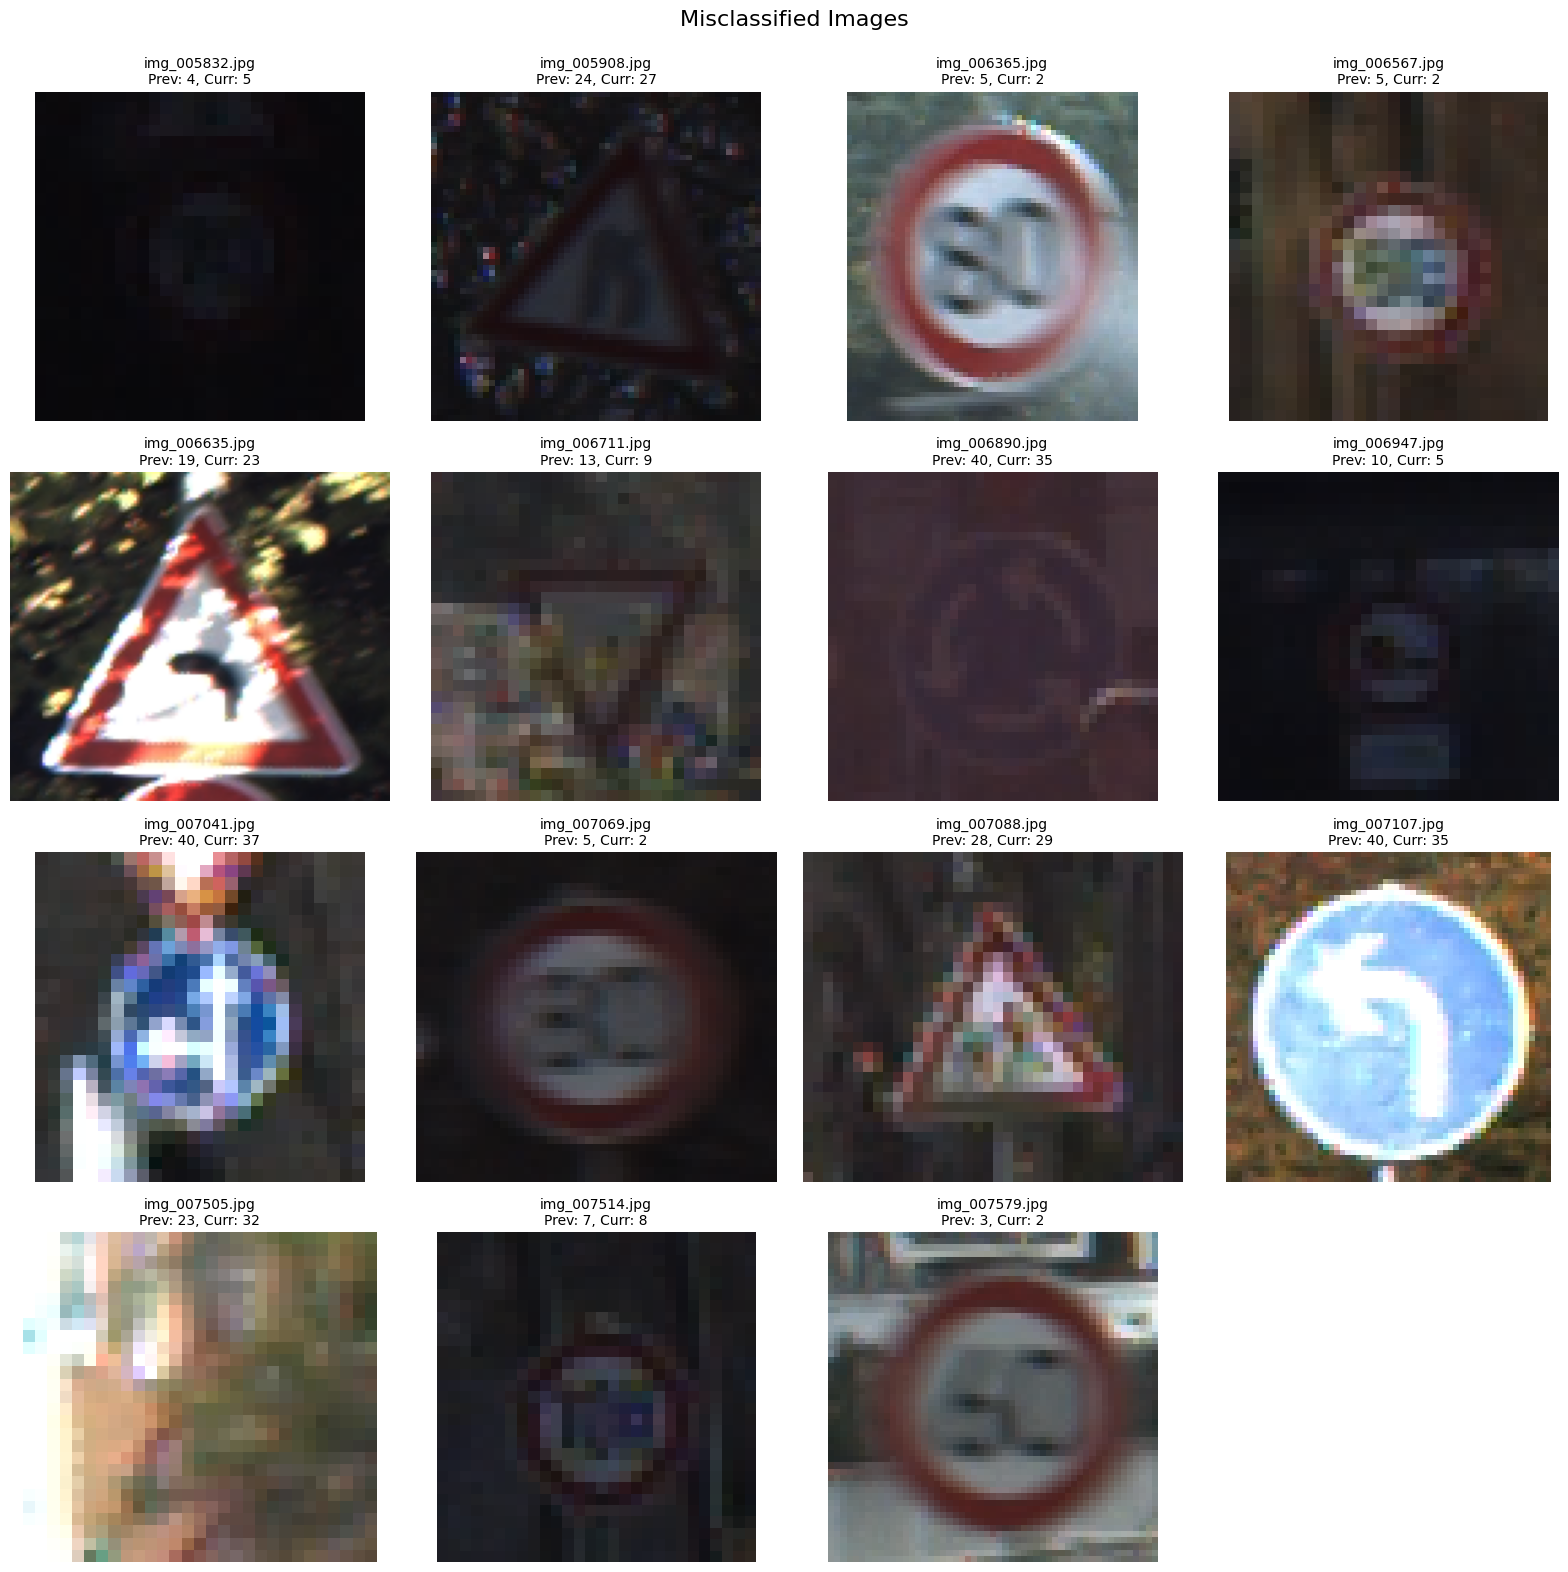

In [23]:
import math

# Compare best predictions with current predictions
prev_df = pd.read_csv('test_100.csv')
curr_df = pd.read_csv('cnn_predictions.csv')

# Get instances where the predictions don't match
indices = prev_df["ClassId"] != curr_df["ClassId"]

prev_labels = prev_df[indices]
curr_labels = curr_df[indices]
image_paths = test_df[indices]['image_path']

num_diff = len(image_paths)
n_cols = 4
n_rows = math.ceil(num_diff / n_cols)

plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for idx, (img_path, prev_row, curr_row) in enumerate(zip(image_paths, prev_labels.itertuples(), curr_labels.itertuples())):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(img_rgb)
    plt.title(f"{img_path.replace('test/', '')}\nPrev: {prev_row.ClassId}, Curr: {curr_row.ClassId}", fontsize=10)
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("Misclassified Images", fontsize=16)
plt.show()